# Introduction

This notebook is a PyTorch starter that uses TPUs.

It is based on HuggingFace's library. I use the already processed data with multilingual Bert.

The approach is to finetune the model with last year's data, and validate on the validation data.


This work is in progress and I will spend some time improving it.

The dataset I use for the pretrained Bert is here : https://www.kaggle.com/theoviel/bertconfigs

### TODO :

- Optimize some parameters

### Updates :
- Switched to tpu, thanks to @youhanlee > https://www.kaggle.com/youhanlee/bert-pytorch-huggingface-tpu-version-xla
- Train on last year's data

# Intialization

### Switching to PyTorch Lightning

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3569  100  3569    0     0  40556      0 --:--:-- --:--:-- --:--:-- 40101
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to nightly ...
Found existing installation: torch 1.4.0
Uninstalling torch-1.4.0:
  Successfully uninstalled torch-1.4.0
Found existing installation: torchvision 0.5.0
Uninstalling torchvision-0.5.0:
  Successfully uninstalled torchvision-0.5.0
Copying gs://tpu-pytorch/wheels/torch-nightly-cp36-cp36m-linux_x86_64.whl...

Operation completed over 1 objects/83.3 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp36-cp36m-linux_x86_64.whl...
Done updating TPU runtime: <Response [200]>

Operation completed over 1 objects/113.4 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly-cp36-cp36m-linux_x86_64.

### Imports

In [2]:
import gc
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
from transformers import *
from sklearn.metrics import *
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

from torch import Tensor
from torch.optim import *
from torch.nn.modules.loss import *
from torch.optim.lr_scheduler import * 
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler

import torch_xla
import torch_xla.core.xla_model as xm

### Seeding

In [3]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
seed = 2020
seed_everything(seed)

# Data

In [5]:
MODEL_PATHS = {
    'bert-multi-cased': '../input/bertconfigs/multi_cased_L-12_H-768_A-12/multi_cased_L-12_H-768_A-12/',
}

In [6]:
DATA_PATH = '../input/jigsaw-multilingual-toxic-comment-classification/'

df_val = pd.read_csv(DATA_PATH + 'validation-processed-seqlen128.csv')
df_test =  pd.read_csv(DATA_PATH + 'test-processed-seqlen128.csv')
df_train = pd.read_csv(DATA_PATH + 'jigsaw-toxic-comment-train-processed-seqlen128.csv')

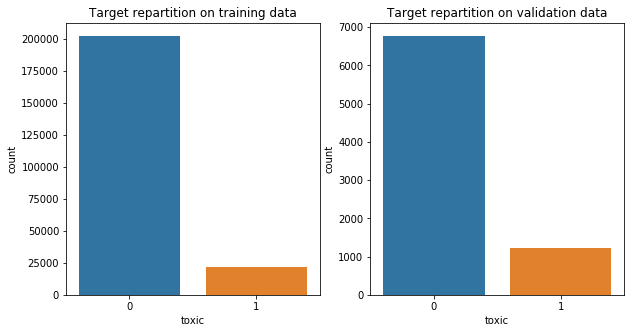

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(df_train['toxic'])
plt.title('Target repartition on training data')

plt.subplot(1, 2, 2)
sns.countplot(df_val['toxic'])
plt.title('Target repartition on validation data')

plt.show()

In [8]:
class JigsawDataset(Dataset):
    """
    Torch dataset for the competition.
    """
    def __init__(self, df):
        """
        Constructor
        
        Arguments:
            df {pandas dataframe} -- Dataframe where the data is. Expects to be one of the []-processed-seqlen128.csv files
        """
            
        super().__init__()
        self.df = df 
        self.word_ids = np.array([word_ids[1:-1].split(', ') for word_ids in df['input_word_ids']]).astype(int)
        
        try:
            self.y = df['toxic'].values
        except KeyError: # test data
            self.y = np.zeros(len(df))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return torch.tensor(self.word_ids[idx]), torch.tensor(self.y[idx])

# Model

In [9]:
TRANSFORMERS = {
    "bert-multi-cased": (BertModel, BertTokenizer, "bert-multi-cased"),
}

In [10]:
class Transformer(nn.Module):
    def __init__(self, model, num_classes=1):
        """
        Constructor
        
        Arguments:
            model {string} -- Transformer to build the model on. Expects "camembert-base".
            num_classes {int} -- Number of classes (default: {1})
        """
        super().__init__()
        self.name = model

        model_class, tokenizer_class, pretrained_weights = TRANSFORMERS[model]

        bert_config = BertConfig.from_json_file(MODEL_PATHS[model] + 'bert_config.json')
        bert_config.output_hidden_states = True
        
        self.transformer = BertModel(bert_config)

        self.nb_features = self.transformer.pooler.dense.out_features

        self.pooler = nn.Sequential(
            nn.Linear(self.nb_features, self.nb_features), 
            nn.Tanh(),
        )

        self.logit = nn.Linear(self.nb_features, num_classes)

    def forward(self, tokens):
        """
        Usual torch forward function
        
        Arguments:
            tokens {torch tensor} -- Sentence tokens
        
        Returns:
            torch tensor -- Class logits
        """
        _, _, hidden_states = self.transformer(
            tokens, attention_mask=(tokens > 0).long()
        )

        hidden_states = hidden_states[-1][:, 0] # Use the representation of the first token of the last layer

        ft = self.pooler(hidden_states)

        return self.logit(ft)

# Training

In [11]:
def fit(model, train_dataset, val_dataset, epochs=1, batch_size=32, warmup_prop=0, lr=5e-5):
    device = xm.xla_device()
    model.to(device)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = AdamW(model.parameters(), lr=lr)
    
    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = epochs * len(train_loader)
    
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    loss_fct = nn.BCEWithLogitsLoss(reduction='mean').to(device)
    
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        
        optimizer.zero_grad()
        avg_loss = 0
        
        for step, (x, y_batch) in tqdm(enumerate(train_loader), total=len(train_loader)): 
            y_pred = model(x.to(device))
            
            loss = loss_fct(y_pred.view(-1).float(), y_batch.float().to(device))
            loss.backward()
            avg_loss += loss.item() / len(train_loader)

            xm.optimizer_step(optimizer, barrier=True)
            scheduler.step()
            model.zero_grad()
            optimizer.zero_grad()
                
        model.eval()
        preds = []
        truths = []
        avg_val_loss = 0.

        with torch.no_grad():
            for x, y_batch in val_loader:                
                y_pred = model(x.to(device))
                loss = loss_fct(y_pred.detach().view(-1).float(), y_batch.float().to(device))
                avg_val_loss += loss.item() / len(val_loader)
                
                probs = torch.sigmoid(y_pred).detach().cpu().numpy()
                preds += list(probs.flatten())
                truths += list(y_batch.numpy().flatten())
            score = roc_auc_score(truths, preds)
            
        
        dt = time.time() - start_time
        lr = scheduler.get_last_lr()[0]
        print(f'Epoch {epoch + 1}/{epochs} \t lr={lr:.1e} \t t={dt:.0f}s \t loss={avg_loss:.4f} \t val_loss={avg_val_loss:.4f} \t val_auc={score:.4f}')

In [12]:
model = Transformer("bert-multi-cased")

In [13]:
epochs = 1 # 1 epoch seems to be enough
batch_size = 32
warmup_prop = 0.1
lr = 2e-5  # Important parameter to tweak

In [14]:
train_dataset = JigsawDataset(df_train)
val_dataset = JigsawDataset(df_val)
test_dataset = JigsawDataset(df_test)

In [15]:
fit(model, train_dataset, val_dataset, epochs=epochs, batch_size=batch_size, warmup_prop=warmup_prop, lr=lr)

# Predicting

In [16]:
def predict(model, dataset, batch_size=64):
    """
    Usual predict torch function
    
    Arguments:
        model {torch model} -- Model to predict with
        dataset {torch dataset} -- Dataset to get predictions from
    
    Keyword Arguments:
        batch_size {int} -- Batch size (default: {32})
    
    Returns:
        numpy array -- Predictions
    """
    device = xm.xla_device()
    model.eval().to(device)
    preds = np.empty((0, 1))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for x, _ in tqdm(loader):
            probs = torch.sigmoid(model(x.to(device))).detach().cpu().numpy()
            preds = np.concatenate([preds, probs])
            
    return preds

In [17]:
pred_val = predict(model, val_dataset)
df_val['pred'] = pred_val

In [18]:
for language in df_val['lang'].unique():
    lang_score = roc_auc_score(
        df_val[df_val['lang'] == language]['toxic'], 
        df_val[df_val['lang']  == language]['pred']
    )
    print(f'AUC for language {language}: {lang_score:.4f}')

AUC for language es: 0.6842
AUC for language it: 0.6079
AUC for language tr: 0.6963


In [19]:
score = roc_auc_score(df_val['toxic'], pred_val)
print(f'Scored {score:.4f} on validation data')

Scored 0.6767 on validation data


In [20]:
pred_test = predict(model, test_dataset)

In [21]:
sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')
sub['toxic'] = pred_test
sub.to_csv('submission.csv', index=False)
sub.head()

,id,toxic
0,0,0.020794
1,1,0.041585
2,2,0.117154
3,3,0.045690
4,4,0.156728
